In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. (Re)install Plotly and the Colab renderer support
!pip install -q plotly "ipywidgets>=7.5"

# 2. Tell Plotly to use the Colab renderer
import plotly.io as pio
pio.renderers.default = "colab"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ealaxi_paysim1_path = kagglehub.dataset_download('ealaxi/paysim1')

print('Data source import complete.')


Data source import complete.


# ✨Introduction

<img src="https://m6r6k8y2.rocketcdn.me/wp-content/uploads/2020/12/cyber-theft-senior-fraud-GIF.gif">

> 🗿**History:** Ever since the advent of internet the digital revolution has rising and has creeped into all aspects to our lives. One of the most important digital revolution happend in financial system and especially transacting money to someone from any part of the world digitally. Digital transactions have become a part of daily life like purchasing a product online, sending money to friends, depositing cash in bank account, investment purposes etc., They had a lot of benefits so does paved way for fradulent activities. People started using digital money transactions medium to launder money and make the money look like it comes from a legal source.
>
> 🎯**Objective:** The objective of this notebook is to find the patterns of transactions performed and help algorithms learn those patterns in identifying the fradulent transactions and flag them
>
> 📌**Goals:**
>1. Exploratory analysis of data to extract the pattern of fraudlent activites
>2. Build a machine learning model to classify fraud and non-fraud transactions
>3. Reduce the false negatives by tuning the model

## 🤝 Libraries

In [ ]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



#Misc libraries
import warnings
warnings.filterwarnings("ignore")

# 🏧 Dataset
> Here we just import the first 50000 rows since the dataset is huge and would take a long time to process. Let's see the overview of data

In [ ]:
print(ealaxi_paysim1_path)

/kaggle/input/paysim1


In [ ]:
!ls /kaggle/input/paysim1

PS_20174392719_1491204439457_log.csv


In [ ]:
#Reading the data
df =pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

#Looking at the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


###Downsampling to the minority class

In [ ]:
import pandas as pd



# 1) Separate classes
frauds     = df[df['isFraud'] == 1]
non_frauds = df[df['isFraud'] == 0]

# 2) Choose your down-sampling ratio:
#    number of non-frauds per fraud (1 => 1 : 1, 3 => 3 : 1, etc.)
ratio = 3

# 3) Sample the non-fraud class
non_frauds_down = non_frauds.sample(
    n = len(frauds) * ratio,
    random_state = 42
)

# 4) Concatenate & shuffle
paysim = pd.concat([frauds, non_frauds_down]).sample(
    frac = 1.0,
    random_state = 42
).reset_index(drop=True)

# 5) Quick sanity check
print("Total rows:", len(paysim))
print("Frauds:",    paysim['isFraud'].sum())
print("Non-frauds:", len(paysim) - paysim['isFraud'].sum())


Total rows: 32852
Frauds: 8213
Non-frauds: 24639


### Dataset description
>1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 📋 Pivot table analysis
>  Numbers is everything in transaction monitoring. Numbers decide whether it is a fraudulent activity or not. Let us look at the overall numbers using pivot function

In [ ]:
#Pivot table

paysim_pivot1=pd.pivot_table(paysim,index=["type"],
                               values=['amount','isFraud','isFlaggedFraud'],
                               aggfunc=[np.sum,np.std], margins=True)

#Adding color gradient
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot1.style.background_gradient(cmap=cm)

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
As per the current rule based algorithm, there has been no flags during fraud transactions incase of cash_out , which a serious concern to the anti money laundering system . Also there are only 16 transactions which are flagged as fraud whereas around 4k transactions are actually fraud. Our mission is now to build an efficient algorithm to mitigate this risk of letting fraud transactions unblocked<br>
<br>   
</div>

In [ ]:
#Pivot table
paysim_pivot2=pd.pivot_table(paysim,index=["type"],
                               values=['amount','oldbalanceOrg','newbalanceOrig'],
                               aggfunc=[np.sum], margins=True)

#Adding style
# paysim_pivot2.style\
#     .format('{:.2f}')\
#     .bar(align='mid',color=['darkred'])\
#     .set_properties(padding='5px',border='3px solid white',width='200px')
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot2.style.background_gradient(cmap=cm)

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
From the table we can understand that most of the customers use the system for transfering money and we have a relatively less data for payments made. Also it is quite interesting to notice the difference between the new and old balance as it tells us some stories. Here we have only the visuals of Orgin account and cash balance have reduced in all cases except cash_in . Even in transfer the balance have reduced which shows that we have more sender information in Original account<br>
<br>   
</div>

In [ ]:
#Pivot table
paysim_pivot3=pd.pivot_table(paysim,index=["type"],
                               values=['amount','oldbalanceDest','newbalanceDest'],
                               aggfunc=[np.sum], margins=True)

#Adding style
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot3.style.background_gradient(cmap=cm)

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
In this table we have the information of destination account , from the transfer information we can see the increase in new balance, hence this is the receiver's info. There is no payment amount available for Dest information.<br>
<br>   
</div>

## 📊 Distribution of Amount
>  It is important to understand the distribution of our data, since it can play a major role in model building and also in understanding our data. Going forward we will be using only 50k rows as it takes a lot of time to process all the records for viz and model building.
> Here we check for the distribution of amount transacted using the application

In [ ]:
#Reading the first 50000 rows

#Distribution of Amount
fig = px.box(paysim, y="amount")
fig.show()

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
From the bar plot we can understand that we have a very right skewed dataset, there are a lot of outliers which goes upto 10M with a median of 33k. The upper bracket(75th percentile) counts upto 450k<br>
<br>   
</div>

# 🔧 Feature engineering
>  Time to get our hands dirty with feature engineering. With the available information it is hard to train the model and get better results. Hence we move onto create new features by altering the existing features. In this we create three functions which creates a highly relevant feature for the domain
>
> 1. **Difference in balance:** It is an universal truth that the amount debited from senders account gets credited into the receivers account without any deviation in cents. But what if there is a deviation incase of the amount debited and credited. Some could be due to the charges levied by the service providers, yet we need to flag such unusual instances
> 2. **Surge indicator:** Also we have to trigger flag when large amount are involved in the transaction. From the distribution of amount we understood that we have a lot of outliers with high amount in transactions. Hence we consider the 75th percentile(450k) as our threshold and amount which is greater than 450k will be triggered as a flag
> 3. **Frequency indicator:** Here we flag the user and not the transaction. When there is a receiver who receives money from a lot of people, it could be a trigger as it can be for some illegal games of chance or luck. Hence it is flagged when there is a receiver who receives money for more than 20 times.
>4. **Merchant indicator:** The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. So we also flag whenever there is a merchant receiver

In [ ]:
#Tallying the balance
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    #Sender's balance
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0:
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']]

    #Receiver's balance
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']]

    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)

#Surge indicator
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    data['surge']=[1 if n>450000 else 0 for n in data['amount']]

#Frequency indicator
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
    data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]

    data.drop(['freq_Dest'],axis=1,inplace = True)

#Tracking the receiver as merchant or not
def merchant(data):
    '''We also have customer ids which starts with M in Receiver name, it indicates merchant
    this function will flag if there is a merchant in receiver end '''
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    data['merchant'] = np.select(conditions, '1', '0')

In [ ]:
#Applying balance_diff function
balance_diff(paysim)

paysim['orig_diff'].value_counts()
paysim['dest_diff'].value_counts()

,count
dest_diff,
1,28874
0,3978


In [ ]:
paysim['orig_diff'].value_counts()


,count
orig_diff,
1,27417
0,5435


In [ ]:
#Applying surge_indicator function
surge_indicator(paysim)
paysim['surge'].value_counts()

,count
surge,
0,27246
1,5606


In [ ]:
#Applying frequency_receiver function
frequency_receiver(paysim)
paysim['freq_dest'].value_counts()

,count
freq_dest,
0,32852


# ⚙️ Pre-processing data
>  Before moving to build a machine learning model, it is mandatory to pre-process the data so that the model trains without any error and can learn better to provide better results

## 1. Balancing the target
> From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.2% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

## 2. One hot encoding
> One of the most important feature we have is type which is categorical in type. Since it doesnt have any ordinal nature and since the classes are less, we prefer applying one hot encoding.

## 3. Split and Standardize
> In this module we create the independent and dependent feature, then split them into train and test data where training size is 70%. Later we collect all the numerical features and apply StandardScaler() function which transforms the distribution so that the mean becomes 0 and standard deviation becomes 1

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Columns to transform
col_names = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

# 1. Create a copy for the transformed data
paysim_standardized = paysim.copy()

# 2. Initialize PowerTransformer (Yeo–Johnson, with built-in centering and scaling)
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# 3. Fit & transform the numeric columns in one step
paysim_standardized[col_names] = pt.fit_transform(paysim_standardized[col_names])

# 4. (Optional) sanity check: means ≈0, stds ≈1
print(paysim_standardized[col_names].describe().loc[['mean','std']])


            amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
mean -8.308086e-17   8.516261e-19    6.143874e-17   -2.352110e-18   
std   1.000015e+00   1.000015e+00    1.000015e+00    1.000015e+00   

      newbalanceDest  
mean    1.873848e-16  
std     1.000015e+00  


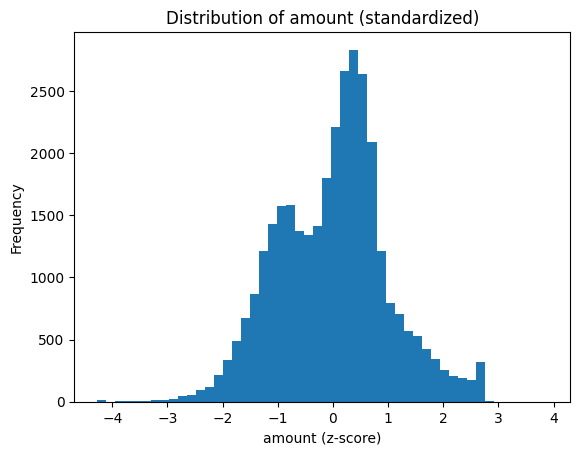

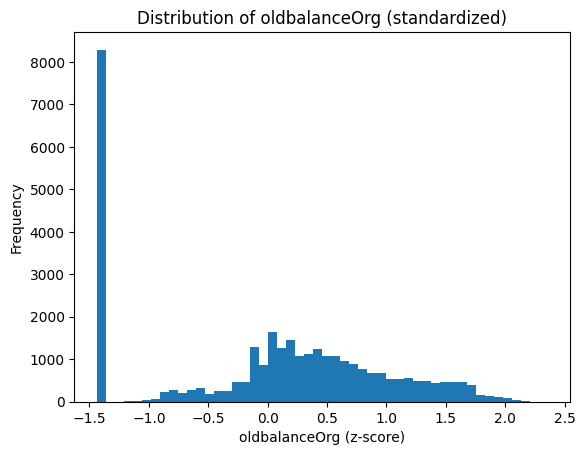

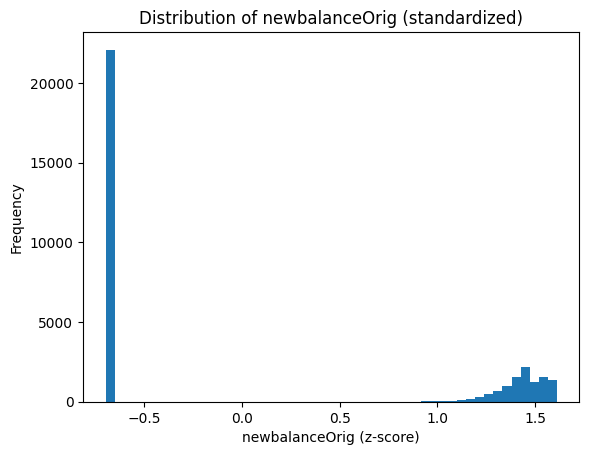

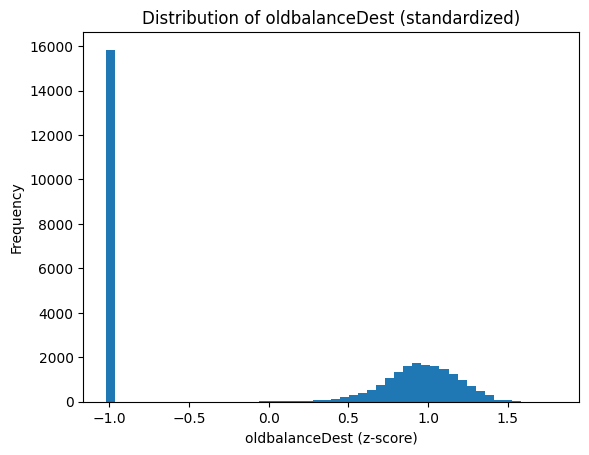

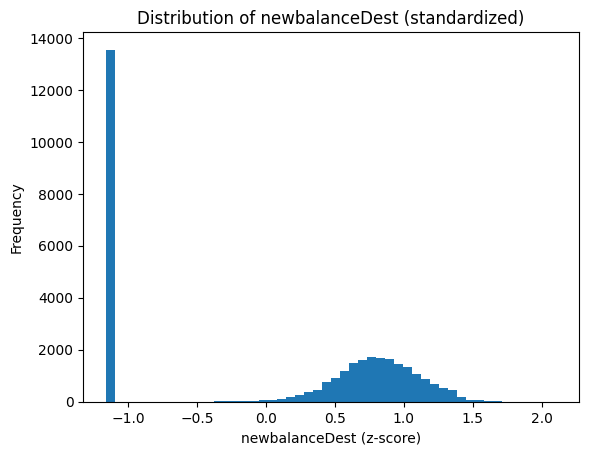

In [ ]:
import matplotlib.pyplot as plt

for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    plt.figure()
    plt.hist(paysim_standardized[col], bins=50)
    plt.title(f"Distribution of {col} (standardized)")
    plt.xlabel(f"{col} (z-score)")
    plt.ylabel("Frequency")
    plt.show()
    plt.close()


### Dropping unnecessary columns
> We dont need the sender and receiver id as we have tokenized them, also we dont required isFlaggedFraud as it is just an outcome of current algorithm.

In [ ]:
#Dropping unnecessary columns
paysim_standardized=paysim_standardized.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
paysim_standardized = paysim_standardized.reset_index(drop=True)
paysim_standardized.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,orig_diff,dest_diff,surge,freq_dest
0,687,CASH_OUT,0.697559,-1.437080,-0.696043,0.930138,0.834508,0,1,1,0,0
1,16,CASH_IN,0.346410,1.520100,1.563533,1.235584,1.164595,0,0,1,0,0
2,42,CASH_IN,0.145551,1.589113,1.568487,0.784008,0.355118,0,0,0,0,0
3,135,CASH_OUT,0.660346,-1.437080,-0.696043,1.049954,0.945664,0,1,1,0,0
4,325,CASH_OUT,-0.011018,0.125443,-0.696043,0.506818,0.453631,0,1,1,0,0


In [ ]:
cols2keep = paysim_standardized.columns.tolist()

paysim = paysim[cols2keep]
paysim.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'orig_diff', 'dest_diff',
       'surge', 'freq_dest'],
      dtype='object')

In [ ]:
path_paysim_standerdized = '/content/drive/MyDrive/RL_states_embeddings/paysim_standardized.csv'
paysim_standardized.to_csv(path_paysim_standerdized, index=False)

In [ ]:
# Generate an LLM‐friendly text description for each transaction (no label)
def make_llm_input(row):
    return (
        f"Step {int(row['step'])}: a {row['type']} of {row['amount']:.2f} units. "
        f"Sender balance went from {row['oldbalanceOrg']:.2f} to {row['newbalanceOrig']:.2f} "
        f"(Δ={row['orig_diff']:.2f}), receiver balance went from {row['oldbalanceDest']:.2f} to "
        f"{row['newbalanceDest']:.2f} (Δ={row['dest_diff']:.2f}). "
        f"Surge flag: {'Yes' if row['surge']==1 else 'No'}. "
    )

# Apply to your DataFrame
paysim['llm_input'] = paysim.apply(make_llm_input, axis=1)

# Peek at a few examples
for txt in paysim['llm_input'].head(3):
    print(txt)


Step 687: a CASH_OUT of 371548.21 units. Sender balance went from 0.00 to 0.00 (Δ=1.00), receiver balance went from 542029.42 to 913577.63 (Δ=1.00). Surge flag: No. 
Step 16: a CASH_IN of 189668.51 units. Sender balance went from 5785679.12 to 5975347.63 (Δ=0.00), receiver balance went from 4457246.94 to 4488943.53 (Δ=1.00). Surge flag: No. 
Step 42: a CASH_IN of 127719.54 units. Sender balance went from 7129413.96 to 7257133.50 (Δ=0.00), receiver balance went from 198588.87 to 70869.32 (Δ=0.00). Surge flag: No. 


In [ ]:
paysim.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'orig_diff', 'dest_diff',
       'surge', 'freq_dest', 'llm_input'],
      dtype='object')

###saving to drive (the downsampled dataset)

In [ ]:
drive_path_paysim = '/content/drive/MyDrive/RL_states_embeddings/paysim_downsampled.csv'

In [ ]:
paysim.to_csv(drive_path_paysim, index=False)  # `index=False` avoids saving row numbers

###Generate states as embeddings: Baseline: Off-the-Shelf Embeddings



In [ ]:
from sentence_transformers import SentenceTransformer


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# ── 1) Specify your baseline model ──
model_name = 'all-MiniLM-L6-v2'

# ── 2) Load the encoder ──
encoder = SentenceTransformer(model_name)

# ── 3) Generate embeddings for all prompts ──
texts = paysim['llm_input'].tolist()
embeddings = encoder.encode(texts, batch_size=64, show_progress_bar=True)

# ── 4) Build a DataFrame of embedding dimensions ──
emb_dim  = embeddings.shape[1]
emb_cols = [f'emb_{i}' for i in range(emb_dim)]
emb_df   = pd.DataFrame(embeddings, columns=emb_cols)

# ── 5) Tag with model name & transaction index ──
emb_df['model']             = model_name
emb_df['transaction_index'] = paysim.index.values

# emb_df now holds your state vectors + metadata.
# (You can .to_csv(), merge back to paysim, or feed directly into your RL agent.)
# For example:
print(emb_df.head())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/514 [00:00<?, ?it/s]

      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.064766  0.061866 -0.040469  0.017848 -0.058255 -0.080943  0.041847   
1 -0.095062  0.054533 -0.022454 -0.013461 -0.067310 -0.093799  0.009118   
2 -0.078835  0.020444 -0.035129 -0.000863 -0.076390 -0.096865  0.016024   
3 -0.069785  0.049262 -0.029349 -0.016755 -0.057639 -0.089731  0.051044   
4 -0.074781  0.030964 -0.042907 -0.017108 -0.053419 -0.096366  0.022810   

      emb_7     emb_8     emb_9  ...   emb_376   emb_377   emb_378   emb_379  \
0  0.020292 -0.024771  0.012607  ... -0.047668 -0.029250 -0.061216  0.036659   
1  0.048699 -0.029411  0.002290  ... -0.058789 -0.074751 -0.086717  0.026421   
2  0.028710 -0.015372  0.000366  ... -0.054366 -0.062237 -0.044174  0.047770   
3  0.003934 -0.026435  0.022236  ... -0.053090 -0.022786 -0.071525  0.034047   
4  0.023044  0.001119  0.002706  ... -0.064342 -0.019367 -0.086901  0.048300   

    emb_380   emb_381   emb_382   emb_383             model  transac



> With the advent of digital transactions, the possibility of money laundering have also soared up with the use of tech. Millions of investigators are on the field fighting against the fraudulent transactions. In the current industry we have a large inflow of false positives hits and it consumes a long time to clear the false positive hits. Customers across the world using fintech platforms demand lightning fast services. Hence automating the hits with machine learning and reducing the false positive hits is our aim. But not at the cost of leaving out the false negatives. Hence we need to be more mindful about false negatives when we try to reduce the false positives

In [ ]:
emb_df.shape

(32852, 386)

In [ ]:
drive_path = '/content/drive/MyDrive/RL_states_embeddings/baseline_MiniLM-l6-v2.csv'

In [ ]:
emb_df.to_csv(drive_path, index=False)  # `index=False` avoids saving row numbers

## BERT-based-uncased

In [ ]:
!pip install -q datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, ClassLabel, Features, Value

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
paysim['isFraud'].value_counts()

,count
isFraud,
0,24639
1,8213


In [ ]:
# 1) Compute raw counts
counts = paysim['isFraud'].value_counts().sort_index()
total  = len(paysim)

# 2) Manually set weights: total_samples / (num_classes * class_count)
weight_0 = total / (2 * counts[0])
weight_1 = total / (2 * counts[1])
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float)
print("Manual class weights:", class_weights)


Manual class weights: tensor([0.6667, 2.0000])


###Build Hugging face dataset

In [ ]:
# 2) Add UID & drop duplicates
paysim['uid'] = paysim.index.values
paysim = paysim.drop_duplicates(subset=['llm_input', 'isFraud'])
print("Data shape after dedup:", paysim.shape)

Data shape after dedup: (32836, 14)


In [ ]:
from datasets import Dataset, ClassLabel, Features, Value

# 1) Select & rename columns, drop any leftover index
df = paysim[['uid','llm_input','isFraud']] \
        .rename(columns={'llm_input':'text','isFraud':'label'}) \
        .reset_index(drop=True)

# 2) Define the schema
features = Features({
    'uid':   Value('int64'),
    'text':  Value('string'),
    'label': ClassLabel(num_classes=2, names=['not_fraud','fraud'])
})

# 3) Build HF Dataset without preserving the pandas index
hf_ds = Dataset.from_pandas(df, features=features, preserve_index=False)

In [ ]:
hf_ds

Dataset({
    features: ['uid', 'text', 'label'],
    num_rows: 32836
})

In [ ]:
# 4) Stratified train/test split
hf_ds = hf_ds.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column='label'
)

### Tokenization and formatting

In [ ]:
# Cell 5: Tokenization and formatting
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch['text'],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = hf_ds['train'].map(tokenize_fn, batched=True)
test_ds  = hf_ds['test'].map(tokenize_fn, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch", columns=['input_ids','attention_mask','labels','uid'])
test_ds.set_format(type="torch", columns=['input_ids','attention_mask','labels','uid'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/26268 [00:00<?, ? examples/s]

Map:   0%|          | 0/6568 [00:00<?, ? examples/s]

In [ ]:
# Cell 6: Metrics function and WeightedTrainer (updated to accept extra args)
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=-1)
    labels = pred.label_ids
    acc = (preds == labels).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weight = self.class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
output_model_path = '/content/drive/MyDrive/fraud-bert-weighted'

In [ ]:
# Cell 7: TrainingArguments & Trainer with Early Stopping
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='/content/best_model',
    num_train_epochs=2,                  # only two epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    bf16=True,                           # BF16 on A100
    logging_dir='./logs_weighted',
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=200,                      # evaluate every 200 steps
    save_strategy='steps',
    save_steps=200,                      # save every 200 steps
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,                  # keep only last 2 checkpoints
    dataloader_drop_last=True,
    seed=42,
    report_to='tensorboard',
    lr_scheduler_type="cosine"
)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Cell 8: Train and evaluate
train_result = trainer.train()
print("Training metrics:", train_result.metrics)

eval_train = trainer.evaluate(eval_dataset=train_ds)
print("Train-set eval:", eval_train)

eval_test = trainer.evaluate(eval_dataset=test_ds)
print("Test-set eval:", eval_test)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.022800,0.028197,0.996951,0.999383,0.988408,0.993865
400,0.026900,0.010028,0.998018,0.993925,0.998170,0.996043
600,0.049200,0.008322,0.999085,0.999388,0.996949,0.998167
800,0.001100,0.011267,0.999085,0.999388,0.996949,0.998167


Training metrics: {'train_runtime': 59.0712, 'train_samples_per_second': 889.367, 'train_steps_per_second': 27.763, 'total_flos': 1683910754304000.0, 'train_loss': 0.12386723684496247, 'epoch': 0.975609756097561}


Train-set eval: {'eval_loss': 0.011531719006597996, 'eval_accuracy': 0.9986280487804878, 'eval_precision': 0.9980134474327629, 'eval_recall': 0.996490692706744, 'eval_f1': 0.9972514887769125, 'eval_runtime': 11.7481, 'eval_samples_per_second': 2235.943, 'eval_steps_per_second': 69.884, 'epoch': 0.975609756097561}
Test-set eval: {'eval_loss': 0.008322285488247871, 'eval_accuracy': 0.9990853658536586, 'eval_precision': 0.999388379204893, 'eval_recall': 0.9969493593654668, 'eval_f1': 0.998167379352474, 'eval_runtime': 3.1372, 'eval_samples_per_second': 2093.592, 'eval_steps_per_second': 65.664, 'epoch': 0.975609756097561}


In [ ]:
!ls /content/best_model/

checkpoint-600	checkpoint-800


In [ ]:
embed_model = model.base_model
embed_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Cell 10: Extract raw embeddings using concatenate_datasets

from datasets import concatenate_datasets
from torch.utils.data import DataLoader
import pandas as pd
import torch

# 1) Combine train & test splits
full_ds = concatenate_datasets([hf_ds['train'], hf_ds['test']])

# 2) Tokenize (if not already) and format
embed_ds = full_ds.map(tokenize_fn, batched=True)
embed_ds = embed_ds.rename_column("label", "labels")
embed_ds.set_format(type="torch", columns=['input_ids','attention_mask','labels','uid'])

# 3) DataLoader
loader = DataLoader(embed_ds, batch_size=32, shuffle=False)

# 4) Collect embeddings
all_uids, all_labels, all_embs = [], [], []
for batch in loader:
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].tolist()
    uids           = batch['uid'].tolist()

    with torch.no_grad():
        out = trainer.model.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = out.last_hidden_state   # [batch, seq_len, hidden]
        mask = attention_mask.unsqueeze(-1)   # [batch, seq_len, 1]
        sum_emb = (last_hidden * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        mean_emb = sum_emb / lengths
        embs = mean_emb.cpu()

    all_uids.extend(uids)
    all_labels.extend(labels)
    all_embs.append(embs)



Map:   0%|          | 0/32836 [00:00<?, ? examples/s]

In [ ]:
# 5) Build DataFrame and save
all_embs = torch.cat(all_embs, dim=0).numpy()
df_emb = pd.DataFrame(all_embs)
df_emb['uid']   = all_uids
df_emb['label'] = all_labels

In [ ]:

drive_path = '/content/drive/MyDrive/fraud-bert-weighted/raw_embeddings_with_labels.csv'
df_emb.to_csv(drive_path, index=False)
print(f"Saved raw embeddings to:\n{drive_path}")


Saved raw embeddings to:
/content/drive/MyDrive/fraud-bert-weighted/raw_embeddings_with_labels.csv


In [ ]:
df_emb['label'].shape

(32836,)

In [ ]:
!ls /content/best_model/

checkpoint-600	checkpoint-800


In [ ]:


!cp -r /content/best_model /content/drive/MyDrive/fraud-bert-weighted/


!echo "Copied best_model, checkpoint-600, checkpoint-800 to Drive."

Copied best_model, checkpoint-600, checkpoint-800 to Drive.


##TRASH


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

# 1. Compute class weights on your full paysim labels
labels = paysim['isFraud'].values
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights = torch.tensor(weights, dtype=torch.float)






In [ ]:
from datasets import Dataset, ClassLabel, Features, Value

# 1) Build your Dataset *with* a ClassLabel feature
features = Features({
    'text':  Value('string'),
    'label': ClassLabel(num_classes=2, names=['not_fraud','fraud'])
})
hf_ds = Dataset.from_pandas(
    paysim[['llm_input','isFraud']].rename(columns={'llm_input':'text','isFraud':'label'}),
    features=features
)

# 2) Now you can stratify by the 'label' column
hf_ds = hf_ds.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column='label'
)

# 3) Tokenize and set format
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_fn(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)

train_ds = (
    hf_ds['train']
      .map(tokenize_fn, batched=True)
      .set_format(type="torch", columns=['input_ids','attention_mask','label'])
)
eval_ds = (
    hf_ds['test']
      .map(tokenize_fn, batched=True)
      .set_format(type="torch", columns=['input_ids','attention_mask','label'])
)




Map:   0%|          | 0/26281 [00:00<?, ? examples/s]

Map:   0%|          | 0/6571 [00:00<?, ? examples/s]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
from collections import Counter

# Inspect the HF Dataset splits
train_labels = hf_ds['train']['label']
test_labels  = hf_ds['test']['label']

print("Train class counts:", Counter(train_labels))
print("Test  class counts:", Counter(test_labels))

# And for relative frequencies:
import pandas as pd
print("\nTrain class proportions:\n", pd.Series(train_labels).value_counts(normalize=True))
print("\nTest class proportions:\n",  pd.Series(test_labels).value_counts(normalize=True))


Train class counts: Counter({0: 19711, 1: 6570})
Test  class counts: Counter({0: 4928, 1: 1643})

Train class proportions:
 0    0.75001
1    0.24999
Name: proportion, dtype: float64

Test class proportions:
 0    0.749962
1    0.250038
Name: proportion, dtype: float64


In [ ]:
!pip install --upgrade transformers


In [ ]:
import torch
import numpy as np
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix


from transformers import AutoModelForSequenceClassification

# 0) Define your model for 2-class classification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# 3) Define a WeightedTrainer that uses class-based loss weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels and do forward pass
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Move class weights onto the same device as model
        device = next(model.parameters()).device
        class_weights = torch.tensor([1.0, 10.0], device=device)

        # Compute weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# 4) Training arguments using legacy flags to avoid unexpected-argument errors
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/fraud-bert-weighted',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_weighted',
    logging_steps=10,
    eval_strategy='epoch',    # run evaluation at each epoch
    save_strategy='epoch',    # save at each epoch
    load_best_model_at_end=True,
    report_to='none'
)

# 5) Define metric computation function
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=-1)
    labels = pred.label_ids
    acc = (preds == labels).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# 6) Instantiate the WeightedTrainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics
)

# 7) Start fine-tuning
eval_results = trainer.train()
print("Training complete.")

# 8) Perform evaluation and detailed reporting
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

pred_out = trainer.predict(eval_ds)
preds = np.argmax(pred_out.predictions, axis=-1)
labels = pred_out.label_ids

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Legitimate', 'Fraud']))

print("\nConfusion Matrix:")
print(confusion_matrix(labels, preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000200,0.007204,0.999391,0.999391,0.998174,0.998782
2,0.000400,0.009640,0.998783,0.996960,0.998174,0.997567
3,0.000300,0.005703,0.999543,1.000000,0.998174,0.999086


Training complete.


Evaluation Metrics: {'eval_loss': 0.0057029868476092815, 'eval_accuracy': 0.9995434484857708, 'eval_precision': 1.0, 'eval_recall': 0.9981740718198417, 'eval_f1': 0.9990862016448371, 'eval_runtime': 12.4167, 'eval_samples_per_second': 529.206, 'eval_steps_per_second': 66.201, 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      4928
       Fraud       1.00      1.00      1.00      1643

    accuracy                           1.00      6571
   macro avg       1.00      1.00      1.00      6571
weighted avg       1.00      1.00      1.00      6571


Confusion Matrix:
[[4928    0]
 [   3 1640]]


In [ ]:
# point this at wherever you want in your MyDrive
out_dir = "/content/drive/MyDrive/RL_states_embeddings/fraud-bert-weighted"

# save the model weights + config + tokenizer
trainer.save_model(out_dir)
tokenizer.save_pretrained(out_dir)

print(f"Model and tokenizer saved to {out_dir}")


Model and tokenizer saved to /content/drive/MyDrive/RL_states_embeddings/fraud-bert-weighted


In [ ]:
model.save_pretrained(out_dir)
